<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам

# Описание признаков в тестовом датасете:
* bodyType - тип кузова
* brand - марка автомобиля 
* car_url - адрес страницы с объявлением 
* color - цвет автомобиля
* complectation_dict - словарь с параметрами комплектации авто
* description - описание автомобиля 
* engineDisplacement - объем двигателя
* enginePower - мощность двигателя
* equipment_dict - словарь оснащения авто 
* fuelType - тип топлива 
* image - изображение 
* mileage - пробег 
* modelDate - дата выпуска модели
* model_info - информация о модели
* model_name - название модели
* name - имя
* numberOfDoors - кол-во дверей
* parsing_unixtime - когда был произведен парсинг данных
* priceCurrency - валюта
* productionDate - год производства
* sell_id
* super_gen - словарь с дополинтельной информацией
* vehicleConfiguration - конфигурация транспортного средства
* vehicleTransmission - трансмиссия
* vendor - страна-изготовитель
* Владельцы - кол-во владельцев
* Владение - период владения
* ПТС
* Привод
* Руль
* Состояние
* Таможня

In [1]:
import numpy as np 
import pandas as pd 
import sys
import time
import datetime
import requests as r
import json
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import pandas_profiling
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import clone

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.2


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
#запишем функцию для вычисления итоговой метрики
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Код парсинга

#в соответствии с условием задачи, нужны данные для Москвы:

START_URL='https://auto.ru/moskva/cars/used/'

pages_url_list=[]

In [5]:
"""while len(pages_url_list)<5000: 
    for i in range(1,99):   
        response = r.get( START_URL+'?page=%s'%i)
        page = BeautifulSoup(response.text, 'html.parser')
        for link in page.findAll('a',{"class": "Link OfferThumb"}):
            try:
                if link['href'] not in pages_url_list: 
                    pages_url_list.append(link['href'])
            except:
                pass
    print(len(pages_url_list))   
    time.sleep(10)"""

'while len(pages_url_list)<5000: \n    for i in range(1,99):   \n        response = r.get( START_URL+\'?page=%s\'%i)\n        page = BeautifulSoup(response.text, \'html.parser\')\n        for link in page.findAll(\'a\',{"class": "Link OfferThumb"}):\n            try:\n                if link[\'href\'] not in pages_url_list: \n                    pages_url_list.append(link[\'href\'])\n            except:\n                pass\n    print(len(pages_url_list))   \n    time.sleep(10)'

Создаем датафрейм с учетом заранее проанализированных признаков, часть из них в test неинформативна, не будем тратить на них время. Используем библиотеку BeautifulSoup. Учитываем условие, что авто должны быть с ценой. Также добавили защиту от ошибок в виде функции try/except. В качестве защиты от капчи на сайте, прописали задержку после каждого цикла 0.1 сек.

In [6]:
"""cars_list = []
for item in pages_url_list:
    response = r.get(item)
    response.encoding = 'utf8'
    page = BeautifulSoup(response.text, 'html.parser')
    if page.find('div', class_='CardSold') == None:
        try:
            json_data = json.loads(
                page.find('script', type="application/ld+json").string)
        except:
            print(item)
            pass
        cls_str = 'CardInfoRow_'
        span_str = 'CardInfoRow__cell'
        try:
            cars_list.append({
            'bodyType': json_data['bodyType'],
            'brand': json_data['brand'],
            'car_url': json_data['offers']['url'],
            'color': json_data['color'],
            'description': json_data['description'],
            'engineDisplacement': json_data['vehicleEngine']['engineDisplacement'],
            'enginePower': json_data['vehicleEngine']['enginePower'],
            'fuelType': json_data['fuelType'],
            'image': json_data['image'],
            'mileage': page.find(
                'li', class_=cls_str+'kmAge').find_all('span')[1].text,
            'modelDate': json_data['modelDate'],
            'model_name': json_data['name'],
            'name': json_data['vehicleEngine']['name'],
            'numberOfDoors': json_data['numberOfDoors'],
            'parsing_unixtime': int(time.time()),
            'priceCurrency': json_data['offers']['priceCurrency'],
            'productionDate': json_data['productionDate'],
            'sell_id': page.find(
                'div', title='Идентификатор объявления').text,
            'vehicleConfiguration': json_data['vehicleConfiguration'],
            'vehicleTransmission': json_data['vehicleTransmission'],
            'Владельцы': page.find(
                'li', class_=cls_str+'ownersCount').find_all('span')[1].text,
            'ПТС': page.find(
                'li', class_=cls_str+'pts').find_all('span')[1].text,
            'Привод': page.find(
                'li', class_=cls_str+'drive').find_all('span')[1].text,
            'Руль': page.find(
                'li', class_=cls_str+'wheel').find_all('span')[1].text,
            'Состояние': page.find(
                'li', class_=cls_str+'state').find_all('span')[1].text,
            'Таможня': page.find(
                'li', class_=cls_str+'customs').find_all('span')[1].text,
            'price': page.find(
                'span', class_='OfferPriceCaption__price').text
            })
        except:
            print(item)
            pass

   # else cars_list = []

    #print('Ожидаю 0.1 секунды...')
    time.sleep(0.1)"""

'cars_list = []\nfor item in pages_url_list:\n    response = r.get(item)\n    response.encoding = \'utf8\'\n    page = BeautifulSoup(response.text, \'html.parser\')\n    if page.find(\'div\', class_=\'CardSold\') == None:\n        try:\n            json_data = json.loads(\n                page.find(\'script\', type="application/ld+json").string)\n        except:\n            print(item)\n            pass\n        cls_str = \'CardInfoRow_\'\n        span_str = \'CardInfoRow__cell\'\n        try:\n            cars_list.append({\n            \'bodyType\': json_data[\'bodyType\'],\n            \'brand\': json_data[\'brand\'],\n            \'car_url\': json_data[\'offers\'][\'url\'],\n            \'color\': json_data[\'color\'],\n            \'description\': json_data[\'description\'],\n            \'engineDisplacement\': json_data[\'vehicleEngine\'][\'engineDisplacement\'],\n            \'enginePower\': json_data[\'vehicleEngine\'][\'enginePower\'],\n            \'fuelType\': json_data[\'f

In [7]:
# переводим в удобный для нас вид
#df = pd.DataFrame(cars_list)
# проверяем на дубликаты, можно по двум признакам car_url или sell_id
#df['sell_id'].duplicated().sum()
# сохраняем в csv
#df.to_csv('cars_df.csv', index=False)

# Setup

In [8]:
VERSION    = 16
VAL_SIZE   = 0.20   # 20%

# Data

In [9]:
train = pd.read_csv('cars_df.csv') # датасет для обучения модели
test = pd.read_csv('test_auto.csv')
sample_submission = pd.read_csv('sample_submission_auto.csv')

In [10]:
train.price.isnull().values.any()

False

In [11]:
train.head(2)

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,...,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price
0,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/e_klas...,чёрный,Автомобиль в который вложена Душа не требует о...,3.2 LTR,220 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,240 000 км,...,1994,SEDAN AUTOMATIC 3.2,автоматическая,3 или более,Оригинал,задний,Левый,Не требует ремонта,Растаможен,3 000 000 ₽
1,хэтчбек 5 дв.,CHEVROLET,https://auto.ru/cars/used/sale/chevrolet/aveo/...,белый,Я СОБСТВЕННИК!!! НЕ ПЕРЕКУП\nМашина в основном...,1.6 LTR,115 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,53 800 км,...,2013,HATCHBACK_5_DOORS AUTOMATIC 1.6,автоматическая,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,638 000 ₽


In [12]:
train.info()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33531 entries, 0 to 33530
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              33531 non-null  object
 1   brand                 33531 non-null  object
 2   car_url               33531 non-null  object
 3   color                 33531 non-null  object
 4   description           33531 non-null  object
 5   engineDisplacement    33531 non-null  object
 6   enginePower           33531 non-null  object
 7   fuelType              33531 non-null  object
 8   image                 33531 non-null  object
 9   mileage               33531 non-null  object
 10  modelDate             33531 non-null  int64 
 11  model_name            33531 non-null  object
 12  name                  33531 non-null  object
 13  numberOfDoors         33531 non-null  int64 
 14  priceCurrency         33531 non-null  object
 15  productionDate        33531 non-null

bodyType                0
brand                   0
car_url                 0
color                   0
description             0
engineDisplacement      0
enginePower             0
fuelType                0
image                   0
mileage                 0
modelDate               0
model_name              0
name                    0
numberOfDoors           0
priceCurrency           0
productionDate          0
vehicleConfiguration    0
vehicleTransmission     0
Владельцы               0
ПТС                     0
Привод                  0
Руль                    0
Состояние               0
Таможня                 0
price                   0
dtype: int64

In [13]:
test.head(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [14]:
test.info()
test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

In [15]:
# первичный осмотр
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(5))
print('Размерность тестового датасета: ', test.shape)
display(test.head(5))

Размерность тренировочного датасета:  (33531, 25)


,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,modelDate,model_name,name,numberOfDoors,priceCurrency,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price
0,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/e_klas...,чёрный,Автомобиль в который вложена Душа не требует о...,3.2 LTR,220 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,240 000 км,1992,Mercedes-Benz E-Класс I (W124) 320,3.2 AT,4,RUB,1994,SEDAN AUTOMATIC 3.2,автоматическая,3 или более,Оригинал,задний,Левый,Не требует ремонта,Растаможен,3 000 000 ₽
1,хэтчбек 5 дв.,CHEVROLET,https://auto.ru/cars/used/sale/chevrolet/aveo/...,белый,Я СОБСТВЕННИК!!! НЕ ПЕРЕКУП\nМашина в основном...,1.6 LTR,115 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,53 800 км,2011,Chevrolet Aveo II,1.6 AT,5,RUB,2013,HATCHBACK_5_DOORS AUTOMATIC 1.6,автоматическая,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,638 000 ₽
2,внедорожник 5 дв.,LAMBORGHINI,https://auto.ru/cars/used/sale/lamborghini/uru...,жёлтый,Год выпуска: 2019. Пробег: 40 100 км. Кузов: в...,4.0 LTR,650 N12,бензин,https://autoru.naydex.net/dVb17C804/f1af98yqCU...,40 100 км,2017,Lamborghini Urus I,4.0 AT,5,RUB,2019,ALLROAD_5_DOORS AUTOMATIC 4.0,автоматическая,1 владелец,Оригинал,полный,Левый,Не требует ремонта,Растаможен,22 000 000 ₽
3,седан,BMW,https://auto.ru/cars/used/sale/bmw/m3/11034070...,синий,"M3 2016 Рестайлинг,Individual в цвете tanzanit...",3.0 LTR,431 N12,бензин,https://autoru.naydex.net/dVb17C804/f1af98yqCU...,50 000 км,2014,BMW M3 V (F80),3.0 AMT,4,RUB,2016,SEDAN ROBOT 3.0,роботизированная,2 владельца,Оригинал,задний,Левый,Не требует ремонта,Растаможен,4 740 000 ₽
4,купе,MCLAREN,https://auto.ru/cars/used/sale/mclaren/720s/11...,чёрный,"В продаже McLaren 720S Perfomance, в идеальном...",4.0 LTR,720 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,4 500 км,2017,McLaren 720S,4.0 AMT,2,RUB,2018,COUPE ROBOT 4.0,роботизированная,1 владелец,Оригинал,задний,Левый,Не требует ремонта,Растаможен,22 500 000 ₽


Размерность тестового датасета:  (34686, 32)


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


## Data Preprocessing

In [16]:
# удаляем дубликаты
train = train.drop_duplicates(subset=['car_url'])

In [17]:
# проверим датасеты на дубликаты по уникальному идентификатору объявления
train['car_url'].duplicated().sum()
test['sell_id'].duplicated().sum()

0

In [18]:
# нам удалось спарсить не все данные(либо в некоторых мы не увидели необходимости), содержащиеся в тестовом датафрейме
# удалим из тестового датафрейма эти признаки (их не так много)
test.drop(['complectation_dict', 'equipment_dict', 'model_info',
           'super_gen', 'vendor', 'Владение'], axis=1, inplace=True)

In [19]:
test['price'] = 0
df_train = train
df_test = test

# удалим строки, где отсутствует цена
df_train = df_train.dropna(axis=0, subset=['price'])

# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [20]:
data.price.isnull().values.any()

False

In [21]:
data.sample(2)

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,modelDate,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,sample
46434,седан,NISSAN,https://auto.ru/cars/used/sale/nissan/primera/...,зелёный,На полном ходу. Мотор и коробка в порядке. Док...,1.6 LTR,99 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,306000,1998,PRIMERA,Nissan Primera II (P11),4,NaN,RUB,1998,NaN,SEDAN MECHANICAL 1.6,механическая,3 или более,Дубликат,передний,Левый,Не требует ремонта,Растаможен,105000,1
58912,седан,TOYOTA,https://auto.ru/cars/used/sale/toyota/prius/11...,серый,"Авто в хорошем состоянии , элетропакет, высоко...",1.5 LTR,58 N12,гибрид,https://autoru.naydex.net/dPnj9f451/637517zlM/...,400000,1999,PRIUS,Toyota Prius I (XW10),4,NaN,RUB,1999,NaN,SEDAN AUTOMATIC 1.5,автоматическая,2 владельца,Оригинал,передний,Правый,Не требует ремонта,Растаможен,270000,1


In [22]:
# еще раз проверим на дубликаты
# Для этого приведем их к одному виду int, т.к. формат в трейне и тесте отличается.
data['car_url'].value_counts()
data = data.drop_duplicates(subset=['car_url'])

In [23]:
data

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,modelDate,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,sample
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,OCTAVIA,1.2 AMT (105 л.с.),5,1.603226e+09,RUB,2014,1.100575e+09,LIFTBACK ROBOT 1.2,роботизированная,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,OCTAVIA,1.6 MT (110 л.с.),5,1.603226e+09,RUB,2017,1.100549e+09,LIFTBACK MECHANICAL 1.6,механическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,SUPERB,DSG 1.8 AMT (152 л.с.),5,1.603226e+09,RUB,2014,1.100658e+09,LIFTBACK ROBOT 1.8,роботизированная,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,OCTAVIA,1.6 AT (110 л.с.),5,1.603226e+09,RUB,2014,1.100937e+09,LIFTBACK AUTOMATIC 1.6,автоматическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,OCTAVIA,1.8 AT (152 л.с.),5,1.603226e+09,RUB,2012,1.101038e+09,LIFTBACK AUTOMATIC 1.8,автоматическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68212,хэтчбек 5 дв.,HONDA,https://auto.ru/cars/used/sale/honda/civic/110...,красный,"Машина в отличном состоянии, есть что передела...",1.5 LTR,115 N12,бензин,https://autoru.naydex.net/VyLm91f05/4c3ef9yM_4...,373317,1999,CIVIC,Honda Civic VI,5,NaN,RUB,1999,NaN,HATCHBACK_5_DOORS MECHANICAL 1.5,механическая,3 или более,Дубликат,передний,Левый,Не требует ремонта,Растаможен,210000,1
68213,компактвэн,HONDA,https://auto.ru/cars/used/sale/honda/stream/11...,серебристый,Продам свою ласточку или поменяю на более деше...,1.7 LTR,130 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,311000,2002,STREAM,Honda Stream I,5,NaN,RUB,2002,NaN,COMPACTVAN AUTOMATIC 1.7,автоматическая,3 или более,Оригинал,передний,Правый,Не требует ремонта,Растаможен,330000,1
68214,седан,HONDA,https://auto.ru/cars/used/sale/honda/civic/110...,серый,"Продаю личный автомобиль. Технически исправен,...",1.8 LTR,140 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,196000,2008,CIVIC,Honda Civic VIII Рестайлинг,4,NaN,RUB,2008,NaN,SEDAN MECHANICAL 1.8,механическая,3 или более,Дубликат,передний,Левый,Не требует ремонта,Растаможен,430000,1
68215,хэтчбек 5 дв.,HONDA,https://auto.ru/cars/used/sale/honda/civic/110...,синий,"В нормальном состоянии, требует внимание кузов...",1.4 LTR,90 N12,бензин,https://autoru.naydex.net/VyLm91f05/4c3ef9yM_4...,350000,2000,CIVIC,Honda Civic VI,5,NaN,RUB,2000,NaN,HATCHBACK_5_DOORS MECHANICAL 1.4,механическая,3 или более,Дубликат,передний,Левый,Не требует ремонта,Растаможен,135000,1


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65609 entries, 0 to 68216
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              65609 non-null  object 
 1   brand                 65609 non-null  object 
 2   car_url               65609 non-null  object 
 3   color                 65609 non-null  object 
 4   description           65609 non-null  object 
 5   engineDisplacement    65609 non-null  object 
 6   enginePower           65609 non-null  object 
 7   fuelType              65609 non-null  object 
 8   image                 65609 non-null  object 
 9   mileage               65609 non-null  object 
 10  modelDate             65609 non-null  int64  
 11  model_name            65609 non-null  object 
 12  name                  65609 non-null  object 
 13  numberOfDoors         65609 non-null  int64  
 14  parsing_unixtime      34686 non-null  float64
 15  priceCurrency      

In [25]:
data.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
description                 0
engineDisplacement          0
enginePower                 0
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime        30923
priceCurrency               0
productionDate              0
sell_id                 30923
vehicleConfiguration        0
vehicleTransmission         0
Владельцы                   0
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
price                       0
sample                      0
dtype: int64

In [26]:
# используем модуль для быстрого первичного анализа данных
#pandas_profiling.ProfileReport(data)

Краткий итог: в тренировочной выборке 33531 объявлений, в тестовой - 34686. Всего данных после удаления дубликатов - 65609 объявлений. Имеется 28 признаков. Из числовых признаков у нас: modelDate, numberOfDoors, productionDate,parsing_unixtime. Остальные - типа Object. Пропуски в признаках price,parsing_unixtime,sell_id появились исскуственно. Также добавился признак sample для обозначения принадлежности данных и последующего разделения.

# Рассмотрим каждый признак

In [27]:
#Будем добавлять признаки в определенный список:
#числовые:
num_cols = []

# бинарные, количество уникальных значений которых равно двум
bin_cols = []

# категориальные
cat_cols = []

**bodyType**

In [28]:
data.bodyType.value_counts()

внедорожник 5 дв.          24589
седан                      23849
хэтчбек 5 дв.               4215
лифтбек                     4159
универсал 5 дв.             2319
минивэн                     1710
купе                        1499
компактвэн                   900
хэтчбек 3 дв.                829
пикап двойная кабина         482
купе-хардтоп                 285
внедорожник 3 дв.            203
фургон                       195
родстер                      166
кабриолет                    126
седан-хардтоп                 29
микровэн                      16
пикап одинарная кабина         9
пикап полуторная кабина        7
седан 2 дв.                    6
лимузин                        6
внедорожник открытый           4
фастбек                        2
тарга                          2
универсал 3 дв.                1
хэтчбек 4 дв.                  1
Name: bodyType, dtype: int64

In [29]:
data['bodyType'] = data['bodyType'].astype(str).apply(lambda x: None if x.strip()=='' else x)
data['bodyType'] = data.bodyType.apply(lambda x: x.split(' ')[0].lower())

In [30]:
data.bodyType.value_counts()

внедорожник      24796
седан            23855
хэтчбек           5045
лифтбек           4159
универсал         2320
минивэн           1710
купе              1499
компактвэн         900
пикап              498
купе-хардтоп       285
фургон             195
родстер            166
кабриолет          126
седан-хардтоп       29
микровэн            16
лимузин              6
фастбек              2
тарга                2
Name: bodyType, dtype: int64

<AxesSubplot:>

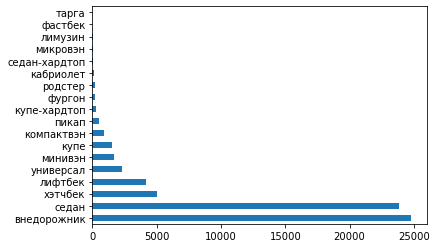

In [31]:
#посмотрим на распределение
data.bodyType.value_counts().plot.barh() 

In [32]:
cat_cols.append('bodyType')

**brand**

In [33]:
data.brand.value_counts()

BMW            8137
VOLKSWAGEN     8106
NISSAN         7793
MERCEDES       7781
TOYOTA         7445
               ... 
GAC               1
DAIHATSU          1
DW_HOWER          1
IRAN_KHODRO       1
MG                1
Name: brand, Length: 70, dtype: int64

In [34]:
cat_cols.append('brand')

**color**

In [35]:
data.color.value_counts()

чёрный         20414
белый          12474
серый           8122
серебристый     6977
синий           6171
коричневый      3012
красный         2928
зелёный         1605
бежевый         1205
голубой          830
золотистый       448
пурпурный        443
фиолетовый       362
жёлтый           341
оранжевый        259
розовый           18
Name: color, dtype: int64

<AxesSubplot:>

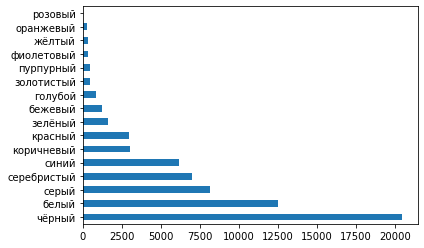

In [36]:
data.color.value_counts().plot.barh() 

Дополнительной обработки признак не требует,пропусков нет,определяем его в "категориальные"

In [37]:
cat_cols.append('color')

**Description**

In [38]:
# description - описание, комментарий продавца
# сгенерируем числовой признак - количество символов в описании
data['description_len'] = data.description.apply(lambda x: len(str(x)))
# сам description удалим

In [39]:
data = data.drop('description',axis=1)

In [40]:
#Определим его как числовой признак
num_cols.append('description_len')

**fuelType**

In [41]:
data.fuelType.value_counts() #категориальный признак

бензин     53453
дизель     11599
гибрид       407
электро      137
газ           13
Name: fuelType, dtype: int64

<AxesSubplot:xlabel='fuelType', ylabel='count'>

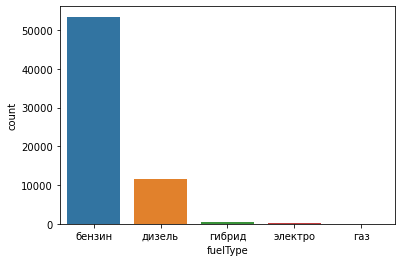

In [42]:
sns.countplot(x = 'fuelType', data = data)

пропусков нет,дополнительной обработки не требуется,добавим признак в категориальные

In [43]:
cat_cols.append('fuelType')

**image**

In [44]:
# image - фото автомобиля
# проверим фото на уникальность
count_photos = data.image.value_counts()
display(count_photos.head(5))

https://avatars.mds.yandex.net/get-verba/216201/2a000001609d0005e0912c12a896bbda4ab1/wizardv3mr     20
https://avatars.mds.yandex.net/get-verba/1030388/2a000001609cf6746b94cf8334836265daaf/wizardv3mr    13
https://avatars.mds.yandex.net/get-verba/216201/2a000001609bda17487cc63d8b957ab4aab2/wizardv3mr     13
https://avatars.mds.yandex.net/get-verba/216201/2a0000016098487a9e1ff58d5ae35f3de345/wizardv3mr     13
https://avatars.mds.yandex.net/get-verba/216201/2a0000016099a4e6be992d7b50134fd908fd/wizardv3mr     12
Name: image, dtype: int64

In [45]:
#получим уникальные фотографии
display(count_photos.sort_values().head(5))

https://avatars.mds.yandex.net/get-autoru-vos/1959786/f96725db2e0c15558c5c4cd1b8613418/320x240                                                                                                                                   1
https://autoru.naydex.net/1xsMU7627/eea2057RFg_/grORHSh_s9quP1CgTz4Z75qpNmv9trfBOhCb2yAUp87j0iTXBvLeCTfOH-380YbfI1D4RkowSvRSjMPeLYDdu9BkA84-O7NLru_U5cyryP1d6aY-KGSiVi5Bh9UpGfwBbVutWknqG8-2Hhj9bUud2_EOfQyfpMN4hxxZn3MIA#DSD    1
https://autoru.naydex.net/ESooa9149/468b9eoMemRk/qYMsjh4E8B__rflVJVfy7b1b-wUX9sx_4S5vynlzIYdgyUPy5qLsUgPJhqpjOZeDxTVMekWnLLNLNgUq6H5lBdkCnXsqYYRKm_yI5dVW1mk4L-5wY3OpuvVpbEg6JdJkwqsgoSCTnfJ3yEKeNa9GBrOQOYznp0qXTMAjiL2w#DSD    1
https://avatars.mds.yandex.net/get-autoru-vos/1583891/89b987e3aebf3f79c8e71e323119db0b/320x240                                                                                                                                   1
https://avatars.mds.yandex.net/get-autoru-vos/2103067/6c78f87ef9b6fa344539ea8595b1affd/320x2

In [46]:
# можно сделать из этого бинарный признак по типу уникальности фото
data['real_photo'] = data.image.apply(lambda x: x.find('get-verba') == -1)

real = data[data['real_photo'] == False].image.value_counts()
display(real.sort_values().head(5))
# сам признак image удалим

https://avatars.mds.yandex.net/get-verba/787013/2a000001609d5bb0770b7ce01e33f1a1dbad/wizardv3mr     1
https://avatars.mds.yandex.net/get-verba/787013/2a000001609d59ca566f47b3959d1c77c72f/wizardv3mr     1
https://avatars.mds.yandex.net/get-verba/787013/2a000001609cef9390faaa4cfa1eba152628/wizardv3mr     1
https://avatars.mds.yandex.net/get-verba/1030388/2a000001609d36f8f97ed8164e4856220e46/wizardv3mr    1
https://avatars.mds.yandex.net/get-verba/787013/2a000001609d10054ff81f13fae7d27a2ed2/wizardv3mr     1
Name: image, dtype: int64

In [47]:
data = data.drop('image',axis=1)

In [48]:
data['real_photo'].value_counts()

True     65046
False      563
Name: real_photo, dtype: int64

<AxesSubplot:xlabel='real_photo', ylabel='count'>

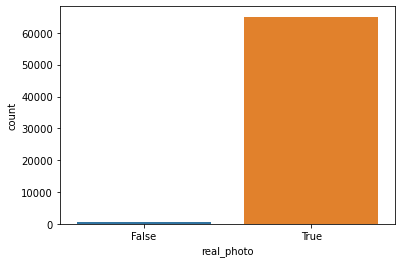

In [49]:
sns.countplot(x = 'real_photo', data = data)

Реальных фото оказалось большинство

In [50]:
bin_cols.append('real_photo')

**engineDisplacement**

In [51]:
data.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', '6.8 LTR', '0.8 LTR', '6.4 LTR', '6.5 LTR', '0.9 LTR',
       '0.6 LTR'], dtype=object)

In [52]:
data.engineDisplacement.value_counts()

2.0 LTR    14515
1.6 LTR     9973
3.0 LTR     7514
1.8 LTR     5805
2.5 LTR     4606
           ...  
6.4 LTR        2
0.6 LTR        1
6.5 LTR        1
3.9 LTR        1
0.9 LTR        1
Name: engineDisplacement, Length: 61, dtype: int64

In [53]:
#оставим только численное значение 
data.engineDisplacement = data.engineDisplacement.apply(lambda x: x[:3])
data.engineDisplacement = data.engineDisplacement.replace(' LT', '2.0')
data.engineDisplacement = data.engineDisplacement.apply(lambda x: float(x))

In [54]:
#разобьем по категориям
data["engineDisplacement"] = data["engineDisplacement"].astype('float').apply(lambda x: 4 if x >= 4 else 
   3 if x >= 3 else(2 if x >= 2 else (1 if x >= 1 else 0)))
data.engineDisplacement.value_counts()

2    25241
1    22562
3    12254
4     5463
0       89
Name: engineDisplacement, dtype: int64

<AxesSubplot:xlabel='engineDisplacement', ylabel='count'>

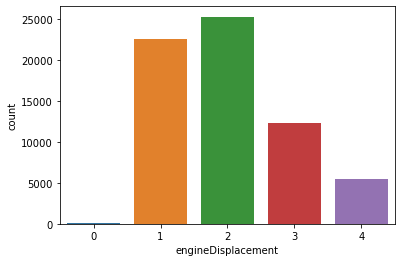

In [55]:
sns.countplot(x = 'engineDisplacement', data = data)

In [56]:
cat_cols.append('engineDisplacement')

**enginePower**

In [57]:
data.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [58]:
#преобразуем данные
data['enginePower'] = data['enginePower'].apply(lambda x: x[:3])
data['enginePower'] = data['enginePower'].replace('7 N','7')
data['enginePower'] = data['enginePower'].apply(lambda x: int(x))

<bound method Axes.barh of <AxesSubplot:>>

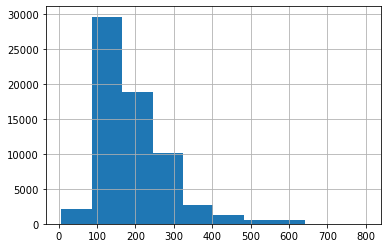

In [59]:
data.enginePower.hist().barh

In [60]:
#добавим в категориальный признак
num_cols.append('enginePower')

**mileage**

In [61]:
data['mileage'].value_counts()

200000        448
300000        392
150000        389
250000        364
180000        353
             ... 
108020          1
147243          1
28142           1
134 062 км      1
32217           1
Name: mileage, Length: 25629, dtype: int64

In [62]:
#Почистим данные
data['mileage'] = data['mileage'].apply(lambda x: str(x).replace('\xa0км', ''))

In [63]:
data['mileage'] = data.mileage.apply(
    lambda x: int("".join(filter(str.isdigit, x))))

count      65609.000000
mean      152734.059931
std        98234.485146
min            1.000000
25%        82450.000000
50%       140000.000000
75%       202667.000000
max      1000000.000000
Name: mileage, dtype: float64

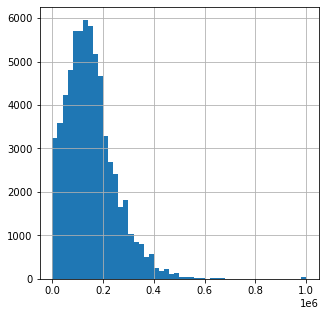

In [64]:
data['mileage'].hist(figsize=(5,5), bins=50)
data.mileage.describe()

In [65]:
#Создадим категориальный признак 'mileage_cat'  
data["mileage_cat"] = data["mileage"].apply(lambda x: 4 if x>=40000 else(3 if x>=30000 else(2 if x>=20000 else (1 if x>=10000 else 0))))

In [66]:
data.mileage_cat.value_counts()

4    58896
3     1845
2     1699
1     1595
0     1574
Name: mileage_cat, dtype: int64

In [67]:
num_cols.append('mileage')
cat_cols.append('mileage_cat')

**productionDate и modelDate**

In [68]:
data.productionDate.value_counts()

2012    5382
2013    4933
2011    4772
2014    4467
2008    4410
        ... 
1962       1
1961       1
1957       1
1948       1
1949       1
Name: productionDate, Length: 74, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


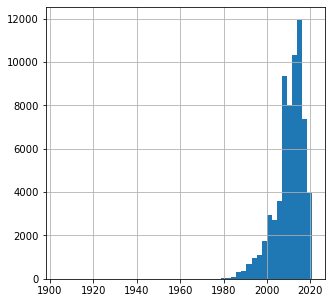

In [69]:
print(data['productionDate'].hist(figsize=(5,5), bins=50))

In [70]:
data.modelDate.value_counts()

2013    4646
2012    4616
2011    4340
2014    4191
2010    4056
        ... 
1904       1
1965       1
1946       1
1952       1
1950       1
Name: modelDate, Length: 73, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


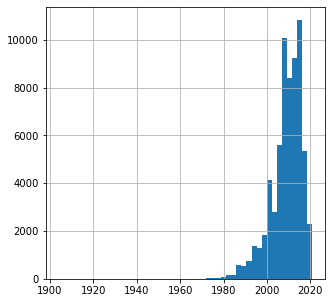

In [71]:
print(data['modelDate'].hist(figsize=(5,5), bins=50))

In [72]:
#создадим новые признаки на основе существующих: количество лет производства и возраст модели
data['prod_age'] = 2021 - data.productionDate
data['model_age'] = 2021 - data.modelDate

In [73]:
#определим эти признаки в числовые данные
num_cols.append('productionDate')
num_cols.append('modelDate')
num_cols.append('prod_age')
num_cols.append('model_age')

**model_name**

In [74]:
data.model_name.unique()

array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', ..., 'VAMOS', 'CAPA', 'MDX'],
      dtype=object)

In [75]:
cat_cols.append('model_name')

**numberOfDoors**

In [76]:
data.numberOfDoors.value_counts() #категориальный признак,не требующий доп.обработки

5    36866
4    25512
2     2129
3     1101
0        1
Name: numberOfDoors, dtype: int64

<AxesSubplot:xlabel='numberOfDoors', ylabel='count'>

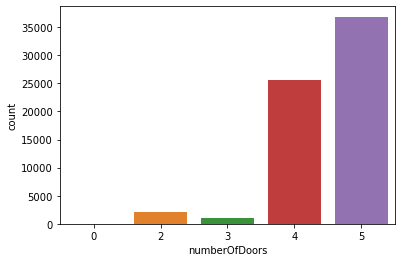

In [77]:
sns.countplot(x = 'numberOfDoors', data = data)

In [78]:
cat_cols.append('numberOfDoors')

**sell_id**

In [79]:
test.sell_id.isna().sum()

0

sell_id - идентификатор объявления,который у нас есть в test-вборке. Из отчета видно, что данный признак уникален, пропусков не осталось. Признак является идентификатором объявления. Смысловой нагрузки не несет, для обучение не отбираем

**vehicleTransmission**

In [80]:
data.vehicleTransmission.value_counts()

автоматическая      37639
механическая        12662
роботизированная     7798
вариатор             7510
Name: vehicleTransmission, dtype: int64

<AxesSubplot:xlabel='vehicleTransmission', ylabel='count'>

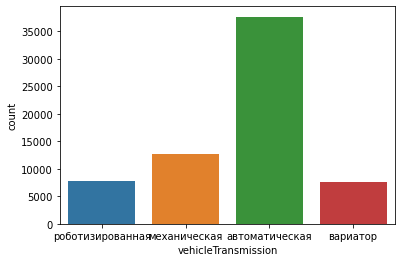

In [81]:
sns.countplot(x = 'vehicleTransmission', data = data)

In [82]:
#определяем в категориальный признак
cat_cols.append('vehicleTransmission')

**Владельцы**

In [83]:
data['Владельцы'].value_counts()

3 или более    27688
1 владелец     11879
2 владельца    10713
1 владелец      8517
2 владельца     6812
Name: Владельцы, dtype: int64

In [84]:
#почистим данные, оставим только количество владельцев
data['Владельцы'] = data['Владельцы'].apply(lambda x: int(x[0])).astype('int32')

In [85]:
data.Владельцы.value_counts()

3    27688
1    20396
2    17525
Name: Владельцы, dtype: int64

<AxesSubplot:xlabel='Владельцы', ylabel='count'>

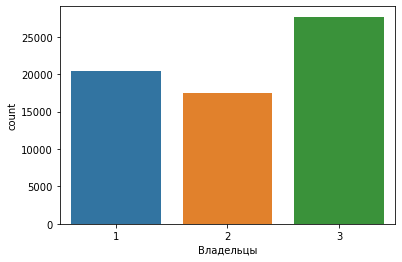

In [86]:
sns.countplot(x = 'Владельцы', data = data)

In [87]:
cat_cols.append('Владельцы')

**ПТС**

In [88]:
data.ПТС.value_counts()

Оригинал    57486
Дубликат     8122
Name: ПТС, dtype: int64

In [89]:
data.ПТС.isna().sum()

1

In [90]:
data.ПТС = data.ПТС.fillna('Оригинал')# заполним пропуск наиболее частым значением

In [91]:
# Преобразуем значения в колонке ПТС
data['ПТС'] = data['ПТС'].apply(lambda x: 1 if x == 'Оригинал' else 0).astype('int8')

<AxesSubplot:xlabel='ПТС', ylabel='count'>

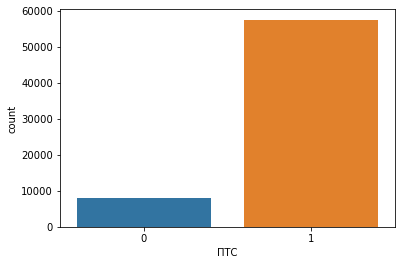

In [92]:
sns.countplot(x = 'ПТС', data = data)

In [93]:
#определяем в бинарные признаки
bin_cols.append('ПТС')

**Привод**

In [94]:
data.Привод.value_counts()

передний    29352
полный      29242
задний       7015
Name: Привод, dtype: int64

<AxesSubplot:xlabel='Привод', ylabel='count'>

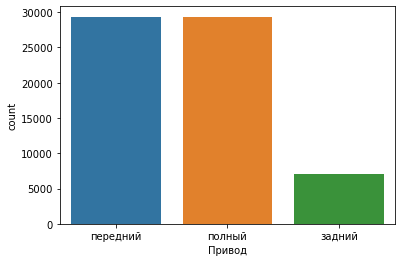

In [95]:
#посмотрим на распределение
sns.countplot(x = 'Привод', data = data)

In [96]:
cat_cols.append('Привод')

**Руль**

In [97]:
data.Руль.value_counts()

Левый     63355
Правый     2254
Name: Руль, dtype: int64

In [98]:
# Преобразуем значения в колонке Руль
data['Руль'] = data['Руль'].apply(lambda x: 1 if x == 'Левый' else 0).astype('int8')

<AxesSubplot:xlabel='Руль', ylabel='count'>

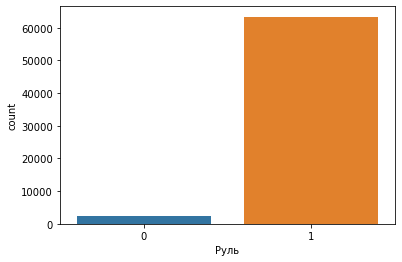

In [99]:
sns.countplot(x = 'Руль', data = data)

In [100]:
bin_cols.append('Руль')

**Состояние**

In [101]:
data.Состояние.unique()

array(['Не требует ремонта', 'Битый / не на ходу'], dtype=object)

In [102]:
# Преобразуем значения в колонке Состояние
data['Состояние'] = data['Состояние'].apply(lambda x: 1 if x == 'Не требует ремонта' else 0).astype('int8')

In [103]:
data.Состояние.value_counts()

1    65607
0        2
Name: Состояние, dtype: int64

In [104]:
bin_cols.append('Состояние')

**Посмотрим на распределение целевой переменной:**

In [105]:
# приведем целевую переменную к числовому типу
data['price'] = data['price'].apply(lambda x: str(x))

In [106]:
# приведем целевую переменную к числовому типу
data.price = data.price.apply(
    lambda x: ("".join(filter(str.isdigit, x)))).astype('int')

<AxesSubplot:title={'center':'Распределение price'}, xlabel='price'>

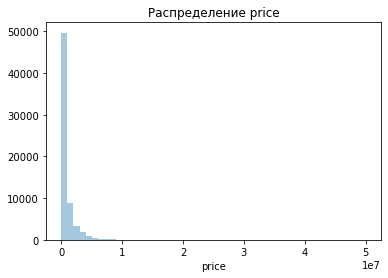

In [107]:
plt.figure()
plt.title(f"Распределение {'price'}")
sns.distplot(data.price, kde=False)

Посмотрим на распределение зависимости цены от марки авто:

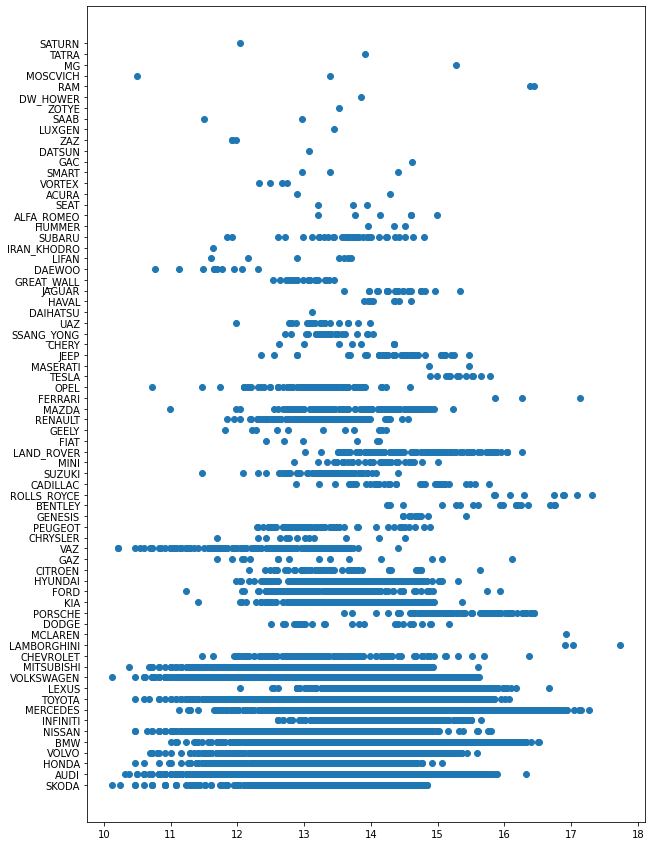

In [108]:
plt.figure(figsize=(10, 15))
plt.scatter(np.log(data.price), data.brand)

Показывает что цены адекватны и зависят от марки авто

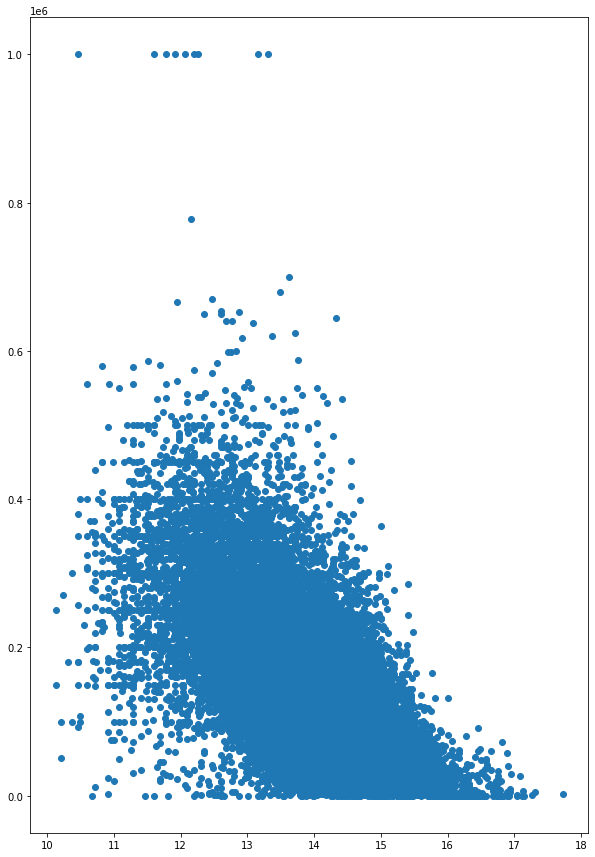

In [109]:
#Посмотрим на распределение зависимости цены от километража
plt.figure(figsize=(10, 15))
plt.scatter(np.log(data.price), data.mileage)

 Удалим признаки, которые на наш взгляд не несут никакой информативности,либо дублируют информацию:

In [110]:
data = data.drop(columns = ['car_url','name','sell_id','parsing_unixtime','vehicleConfiguration','priceCurrency','Таможня'], axis=1)

In [111]:
data.head(2)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,price,sample,description_len,real_photo,mileage_cat,prod_age,model_age
0,лифтбек,SKODA,синий,1,105,бензин,74000,2013,OCTAVIA,5,2014,роботизированная,3,1,передний,1,1,0,0,1001,True,4,7,8
1,лифтбек,SKODA,чёрный,1,110,бензин,60563,2017,OCTAVIA,5,2017,механическая,1,1,передний,1,1,0,0,2609,True,4,4,4


## Label Encoding

In [112]:
for colum in ['bodyType','color','model_name','brand','fuelType', 'vehicleTransmission','Привод','real_photo']:
    data[colum] = data[colum].astype('category').cat.codes

In [113]:
data.sample(5)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,price,sample,description_len,real_photo,mileage_cat,prod_age,model_age
59491,11,43,0,1,109,0,138000,2011,965,4,2011,0,1,1,1,1,1,550000,1,1553,1,4,10,10
47926,0,40,15,4,544,0,104000,2013,664,5,2013,0,2,1,2,1,1,4700000,1,105,1,4,8,8
51770,0,34,13,2,150,0,5000,2020,1417,5,2020,1,1,1,2,1,1,3300000,1,138,1,0,1,1
51072,0,40,1,3,333,0,139000,2014,648,5,2014,0,2,1,2,1,1,2350000,1,86,1,4,7,7
52984,0,4,1,3,306,0,70690,2013,2130,5,2013,0,1,1,2,1,1,2197000,1,1227,1,4,8,8


In [114]:
print('Категориальныe: {} \nБинарные: {}\nЧисловые: {}'.format(cat_cols, bin_cols,num_cols))

Категориальныe: ['bodyType', 'brand', 'color', 'fuelType', 'engineDisplacement', 'mileage_cat', 'model_name', 'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Привод'] 
Бинарные: ['real_photo', 'ПТС', 'Руль', 'Состояние']
Числовые: ['description_len', 'enginePower', 'mileage', 'productionDate', 'modelDate', 'prod_age', 'model_age']


# Бинарные признаки

In [115]:
for i in bin_cols:
    display(data[i].value_counts())

1    65046
0      563
Name: real_photo, dtype: int64

1    57487
0     8122
Name: ПТС, dtype: int64

1    63355
0     2254
Name: Руль, dtype: int64

1    65607
0        2
Name: Состояние, dtype: int64

<AxesSubplot:>

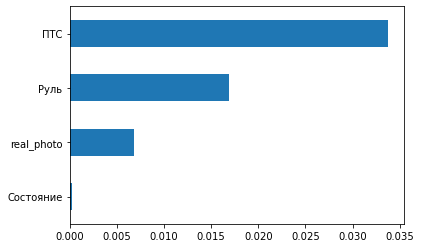

In [116]:
#Проверим значимость бинарных переменных:
df = data[data['sample'] == 0]
imp_cat = Series(mutual_info_classif(data[bin_cols], data['price'],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

по графику видим,что сильно больше всего влияют признаки ПТС и Руль на цену

<AxesSubplot:>

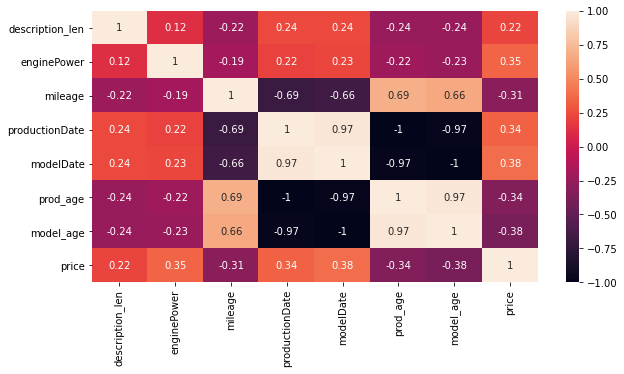

In [117]:
# построим матрицу корреляций для числовых признаков
plt.figure(figsize=(10,5))
sns.heatmap(data[num_cols+['price']].corr(), annot=True)

# Категориальные признаки

<AxesSubplot:>

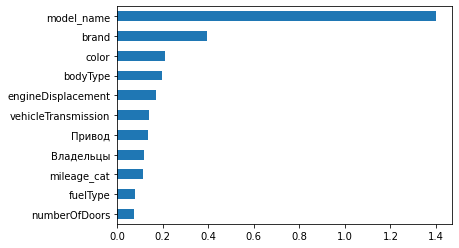

In [118]:
# Проверим значимость категориальных переменных:
temp_df = data[data['sample']==1]
imp_cat = Series(mutual_info_classif(data[cat_cols], data['price'],
                                     discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Логично,что цена будет зависеть от марки и модели машины

# Числовые признаки

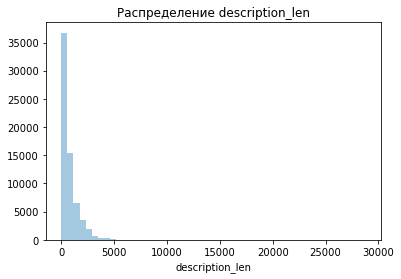

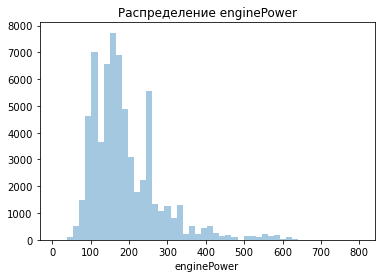

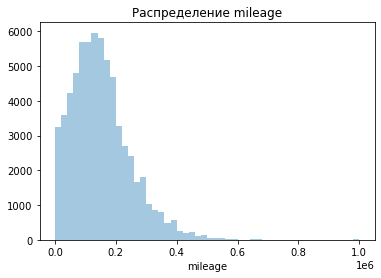

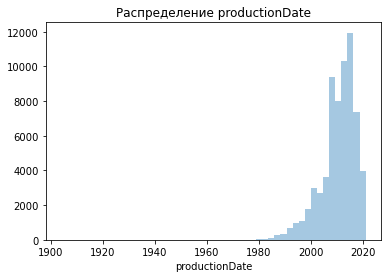

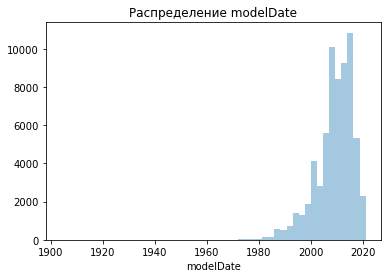

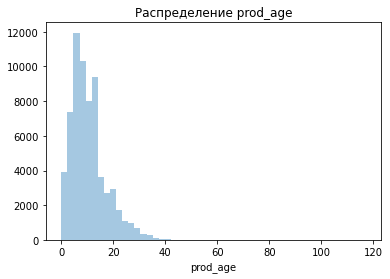

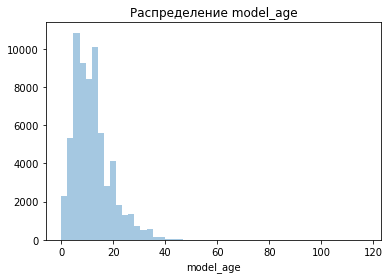

In [119]:
# анализ распределения числовых переменных с помощью визуализации
for col in num_cols:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(data[col], kde=False)

<AxesSubplot:>

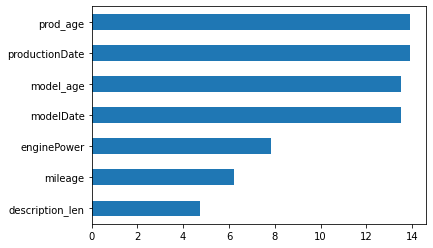

In [120]:
imp_num = Series(f_classif(data[num_cols][data['sample'] == 1], data[data['sample'] == 1]['price'])[0], 
                 index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Все признаки достаточно сильно влияют на цену

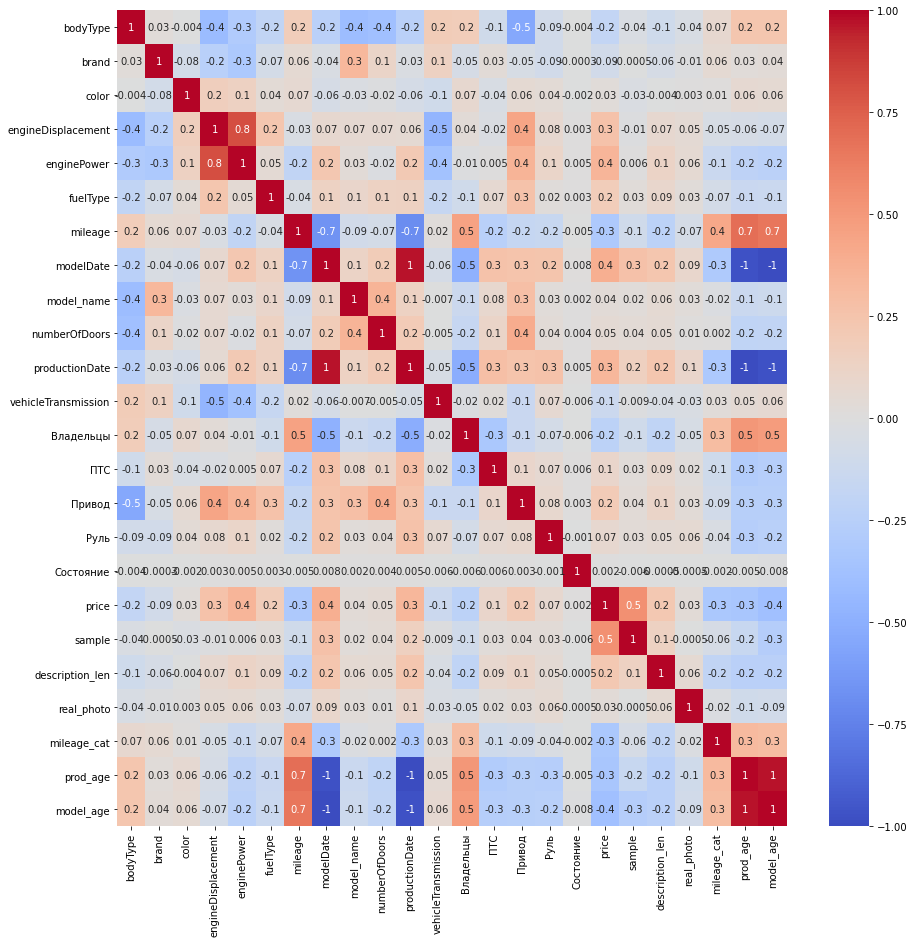

In [121]:
# корреляция

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax = sns.heatmap(data.corr(),fmt='.1g',
                 annot=True, cmap='coolwarm')

Видна большая корреляция между признаками 'engineDisplacement' и 'enginePower',а так же искуственно созданными признаками. Удалять не будем,тк проведя эксперименты по машинному обучению,заметили, что результат метрики хуже.

## Train Split

In [122]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample','price'], axis=1)
X = train_data.drop(['price'], axis=1)
y = train_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [123]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [127]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())
VERSION = 1
#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 95.03%


# Простая модель линейной регрессии

In [126]:
from sklearn.linear_model import LinearRegression
linear_regr = LinearRegression().fit(X_train, np.log(y_train+1))
VERSION = 2
#predict_test = np.exp(linear_regr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

NameError: name 'predict_test' is not defined

# CatBoost


In [127]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [128]:
# оцениваем точность
VERSION = 3
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 14.96%


### Log Target
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    

In [129]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')
predict_test = np.exp(model.predict(X_test))
#predict_submission = np.exp(model.predict(test_data))
VERSION = 4
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 12.52%


# Random Forest

In [130]:
rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1).fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf.predict(X_test))))*100:0.2f}%")
VERSION = 5
#predict_submission = np.exp(rf.predict(test_data))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s


Точность модели по метрике MAPE: 14.19%


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


**закомментируем, тк очень долго работает:**

In [131]:
#Зададим сетку гиперпараметров, которые будут перебираться:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [132]:
#Обучим наш лес:
#rf = RandomForestRegressor(random_state=42)
#rf_rand = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
#                              cv=3, verbose=2, random_state=42, n_jobs=-1)
#rf_random.fit(X_train, np.log(y_train+1))

In [133]:
#print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf.predict(X_test))))*100:0.2f}%")
VERSION = 6
#predict_submission = np.exp(rf_random.predict(test_data))


# xgboost

In [134]:
# xgboost
import xgboost as xgb
xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)
xb.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(xb.predict(X_test))))*100:0.2f}%")
VERSION = 7
predict_test = np.exp(xb.predict(X_test))
predict_submission = np.exp(xb.predict(test_data))

Точность модели по метрике MAPE: 12.14%


# GradientBoosting с подбором параметров

In [135]:
from sklearn.ensemble import GradientBoostingRegressor
def regularise(X_train, y_train):
    max_depth = [5, 10,15]
    n_estimators = [100, 200,1000]
    hyperparameters = dict(max_depth=max_depth, n_estimators=n_estimators)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    clf = GridSearchCV(model, hyperparameters)

    best_model = clf.fit(X_train, y_train)

    best_max_depth = best_model.best_estimator_.get_params()['max_depth']
    best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']

    return best_max_depth, best_n_estimators

In [136]:
#ОЧЕНЬ ДОЛГО РАБОТАЕТ,ЗАКОММЕНТИРУЕМ
#best_max_depth, best_n_estimators = regularise(X_train, y_train)
#best_max_depth, best_n_estimators

(5, 1000)

In [137]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=5, n_estimators=1000)
gb.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(gb.predict(X_test))))*100:0.2f}%")
VERSION = 8

Точность модели по метрике MAPE: 13.81%


# Stacking

In [138]:
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 


y_train = y_train 
y_test = y_test

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

def compute_meta_feature(regr, X_train, X_test, y_train, cv):
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    
    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)

    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_test)


    return X_meta_train, X_meta_test

def generate_meta_features(regr, X_train, X_test, y_train, cv):
    features = [compute_meta_feature(regr, X_train, X_test, y_train, cv) for regr in tqdm(regr)]    
    stacked_features_train = np.vstack([features_train for features_train, features_test in features]).T
    stacked_features_test = np.vstack([features_test for features_train, features_test in features]).T
    return stacked_features_train, stacked_features_test

X_train = np.where(np.isnan(X_train), 0, X_train)
X_test = np.where(np.isnan(X_test), 0, X_test)
y_train = np.where(np.isnan(y_train), 0, y_train)

In [139]:
regr = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1, 
                             max_features=3, max_depth=19, bootstrap=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test = generate_meta_features([
                            regr,
                            GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300),
                            KNeighborsRegressor(n_neighbors=2, algorithm = 'ball_tree', weights = 'distance', p=1),
                            RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1, max_depth=5, n_estimators=200),
                            ExtraTreesRegressor(random_state=RANDOM_SEED), 
                            RandomForestRegressor(random_state=RANDOM_SEED, max_depth=15) \
], X_train, X_test, y_train, cv)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

In [140]:
def compute_metric(regr, X_train, y_train, X_test, y_test): 
    regr.fit(X_train, y_train) 
    y_test_pred = regr.predict(X_test) 
    return np.round(mape(y_test, y_test_pred)*100, 2)
VERSION = 9
print(f"Точность модели по метрике MAPE: {compute_metric(regr, stacked_features_train, y_train, stacked_features_test, y_test)}%")

Точность модели по метрике MAPE: 14.71%


Проведя ряд экспериментов можно сделать следующие выводы:
* CatBoost и GradientBoosting отлично справляется и показывает хороший результат метрики, но лучший результат показал xgboost - 12.14.
* Заметно улучшается результат после логарифмирования целевой переменной
* так же удалось поэксперементировать со стекингом с различными мета-алгоритмами.

Результаты можно улучшить спарсив больше данных и провести больше обработки над признаками,создав новые, но из-за нехватки времени этого не успели сделать.

# Submission

In [141]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.697804e+05
1,1100549428,9.962137e+05
2,1100658222,9.239507e+05
3,1100937408,7.974400e+05
4,1101037972,7.523437e+05
5,1100912634,7.435708e+05
6,1101228730,6.611716e+05
7,1100165896,4.483103e+05
8,1100768262,2.138524e+06
9,1101218501,8.035688e+05


# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing